# Historical and future simulation of hailstorms in Australia

In [1]:
%cd git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import xarray
import numpy as np
import cartopy.crs as ccrs
from importlib import reload
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'   # Data base directory.
hist_years = np.arange(1989,2009)                   # Historical years.
fut_years = np.arange(2080,2100)                    # Future years.
wrf_template_dir = f'{base_dir}/WRF_v4.4/template/' # Template directory for WRF/WPS setups.
sims_dir = f'{base_dir}/WRF_v4.4/simulations'       # Simulation directory.

In [4]:
client = Client()

## Domain setup

This code lets us experiment with domain setups in a fast way to get the nesting structure correct and domains in the right places.

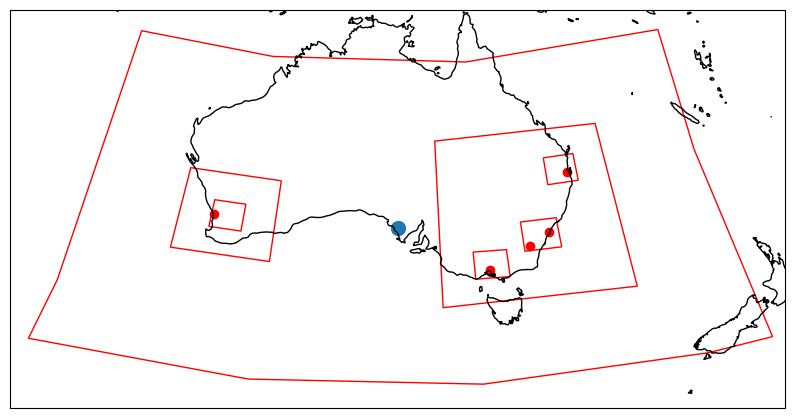

parent_id = 1, 1, 2, 1, 4, 4, 4,
i_parent_start = 1, 34, 34, 126, 34, 123, 87,
j_parent_start = 1, 51, 34, 34, 34, 144, 64,
e_we = 223, 103, 103, 190, 103, 103, 115,
e_sn = 136, 103, 103, 211, 103, 103, 112,
dx = 0.25
dy = 0.25
ref_lat = -33.4
ref_lon = 135.2
pole_lat = 56.6
pole_lon = 0
stand_lon = 44.8


In [5]:
#                                       outer, west, perth, east, melb, bris, cbr-syd,
hf.plot_wrf_domain_def(parent_id      = [    1,    1,     2,    1,    4,    4,      4],
                       i_parent_start = [    1,   34,    34,  126,   34,  123,     87],
                       j_parent_start = [    1,   51,    34,   34,   34,  144,     64],
                       e_we           = [  223,  103,   103,  190,  103,  103,    115],
                       e_sn           = [  136,  103,   103,  211,  103,  103,    112],
                       dx=0.25,
                       dy=0.25,
                       ref_lat=-33.4, 
                       ref_lon=135.2,
                       num_doms=7,
                       scale_factor=3,
                       pts=hf.cities)

Now, after namelist.wps has been updated and geogrid.exe has been run, we can plot the real domains, which should be close to the estimated version above:

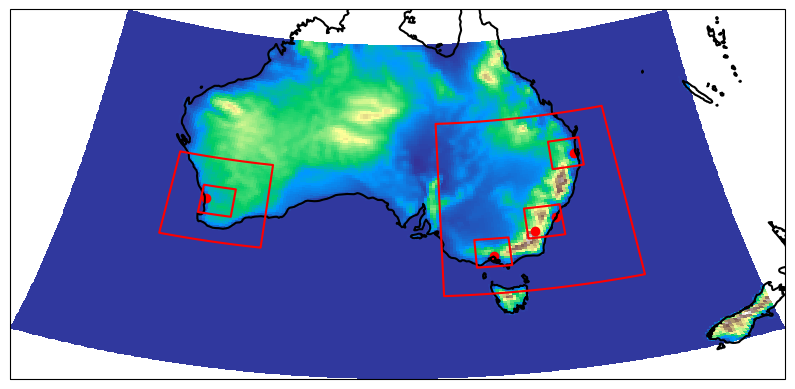

In [6]:
hf.plot_wrf_domains(wps_dir=f'{base_dir}/WRF_v4.4/simulations/hist/1989-1990/WPS', pts=hf.cities)

## Input data

WRF boundary conditions are supplied from [Xu et al., 2021](https://www.nature.com/articles/s41597-021-01079-3) (data are CC-BY-4.0):

- Publication: https://www.nature.com/articles/s41597-021-01079-3
- Data archive: https://www.scidb.cn/en/detail?dataSetId=791587189614968832

Write scripts that can be run to download all the boundary condition data. Note that the land conditions need to be downloaded and unzipped; these are single files available from the data archive link above.

In [10]:
# hf.gen_download_script(years=hist_years, out_file=f'{base_dir}/xu_data/hist/download_hist.sh')
# hf.gen_download_script(years=fut_years, out_file=f'{base_dir}/xu_data/ssp245/download_ssp245.sh', fut_ssp='ssp245')

<module 'modules.hist_fut_hail' from '/home/561/tr2908/git/hist_future_hail/modules/hist_fut_hail.py'>

## WRF setup

In [6]:
for year in hist_years:
    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, sims_dir=sims_dir+'/hist/', exp='hist')
#for year in fut_years:
#    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, sims_dir=sims_dir+'/ssp245/', exp='ssp245')

Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...
Skipping existing WPS...


To run WPS and WRF:
    
```
cd /g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/hist
for i in *; do cd $i/WPS/; qsub ~/git/hist_future_hail/scripts/run_WPS.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_real.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_WRF.sh; cd ../../; done
```

## Output

In [7]:
d = f'{base_dir}/WRF_v4.4/simulations/hist/1989-1990/WRF'
print(d)

/g/data/up6/tr2908/hist_future_hail//WRF_v4.4/simulations/hist/1989-1990/WRF


In [8]:
perth = xarray.open_mfdataset(f'{d}/wrfout_d03_*', parallel=True, combine='nested', concat_dim='Time')
melb = xarray.open_mfdataset(f'{d}/wrfout_d05_*', parallel=True, combine='nested', concat_dim='Time')
bris = xarray.open_mfdataset(f'{d}/wrfout_d06_*', parallel=True, combine='nested', concat_dim='Time')
cbr_syd = xarray.open_mfdataset(f'{d}/wrfout_d07_*', parallel=True, combine='nested', concat_dim='Time')

In [9]:
perth

<xarray.Dataset>
Dimensions:                (Time: 29, south_north: 102, west_east: 102,
                            bottom_top: 79, bottom_top_stag: 80,
                            soil_layers_stag: 4, west_east_stag: 103,
                            south_north_stag: 103, seed_dim_stag: 2,
                            snow_layers_stag: 3, snso_layers_stag: 7)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(24, 102, 103), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(24, 102, 103), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(24, 103, 102), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(24, 103, 102), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag,
                                seed_dim_stag, snow_layers_stag,
                                snso_layers_stag
Data variables: (12/376)
    Times                  (Time) |S19 dask.array<chunksize=(24,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(24, 79), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(24, 80), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(24, 4), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(24, 4), meta=np.ndarray>
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    PC                     (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    LANDMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    LAKEMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    SST                    (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    SST_INPUT              (Time, south_north, west_east) float32 dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
Attributes: (12/153)
    TITLE:                            OUTPUT FROM WRF V4.4.1 MODEL
    START_DATE:                      1989-09-30_00:00:00
    SIMULATION_START_DATE:           1989-09-30_00:00:00
    WEST-EAST_GRID_DIMENSION:        103
    SOUTH-NORTH_GRID_DIMENSION:      103
    BOTTOM-TOP_GRID_DIMENSION:       80
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [9]:
def plot_time(doms, titles=None, t=3, f='', pts=None, nrow=1, ncol=4, figsize=(12,4)):
    assert ncol * nrow >= len(doms), 'Insufficient rows/columns.'
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, nrows=nrow, ncols=ncol, figsize=figsize)
    
    for i, d in enumerate(doms):
        x = d.isel(Time=t).XLONG
        y = d.isel(Time=t).XLAT
        z = d.isel(Time=t)[f]

        ax.flat[i].pcolormesh(x, y, z, transform=ccrs.PlateCarree())
        ax.flat[i].coastlines(color='blue')
    
        if not titles is None:
            ax.flat[i].set_title(titles[i])
    
        # Add optional points.
        if not pts is None:
            for j in pts[i].keys():
                ax.flat[i].scatter(pts[i][j][0], pts[i][j][1], color='red')                          

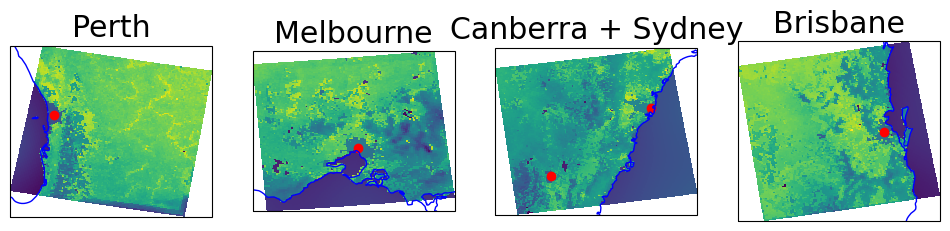

In [10]:
plot_time(doms=[perth, melb, cbr_syd, bris], 
          titles=['Perth', 'Melbourne', 'Canberra + Sydney', 'Brisbane'],
          f='TSK',
          pts=[{x: hf.cities[x] for x in ['Perth']},
               {x: hf.cities[x] for x in ['Melbourne']},
               {x: hf.cities[x] for x in ['Canberra', 'Sydney']},
               {x: hf.cities[x] for x in ['Brisbane']}])

In [ ]:
perth.isel(Time=0)